####Introduction
Original Source: https://github.com/h-fuzzy-logic/python-windspeed

From the original file: Example of using TPUs for CNN to predict windspeed from satellite image of hurricane.  Images are in a Google Bucket in TFRecord format (instead of JPG) to reduce model training time.  TFRecord format allows for more efficient streaming to the model.  

During training, the model checkpoints are saved for the best MSE.  After traning, the final model is saved.   

Modification:
This code has been modified to work with TFRecord files stored in Google drive.

####**Initial Setup**
Prepare to connect to Google Drive plus other imports

In [ ]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()        # asks for user google credentials

In [ ]:
import datetime
import numpy as np
import os

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *         # experimental preprocessing was transported to layers in 07/24
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint



####**TPU Setup**
If and Google Store and TPUs are used , this cell connects to cluster and set distribution strategy

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

KeyError: 'COLAB_TPU_ADDR'

####**Data Files**
Connect to your Google Drive and verify TFRecord file entries look OK.

In [ ]:
#Define function to map a TFRecordFile
def read_one_whole_rec(data):                           #read one whole record from the TFRecordFile
  tfrecord_format = (
        {
            "x": tf.io.FixedLenFeature([], tf.string),   #Image data
            "y": tf.io.FixedLenFeature([], tf.float32)  # Winspeed float value
        }
   )

  data = tf.io.parse_example(data, tfrecord_format)  # extract one record of the TFRecord file
  img = tf.io.decode_raw(data["x"], tf.uint8)   #extract the image

  #expecting this original imgage size
  img = tf.reshape(img, [366,366,1])      # ensure image size

  lab = data["y"]       #extracting the label information, winspeed float representing miles /hour
  return img, lab       #returning the image and label

# Train set and validation set was converted to TFRecords in other file.

train_images = tf.data.TFRecordDataset(                   #define dataset of training images and labels taken from a TFRecordFile.
    "/content/drive/MyDrive/data/train2.tfrecords"
)

ds_train = train_images.map(read_one_whole_rec)           #map the dataset following the funcion

val_images = tf.data.TFRecordDataset(                   #define dataset of validation images and labels taken from a TFRecordFile.
     "/content/drive/MyDrive/data/val2.tfrecords"
)
ds_val = val_images.map(read_one_whole_rec)              #map the dataset following the funcion


Windspeed is 43.0


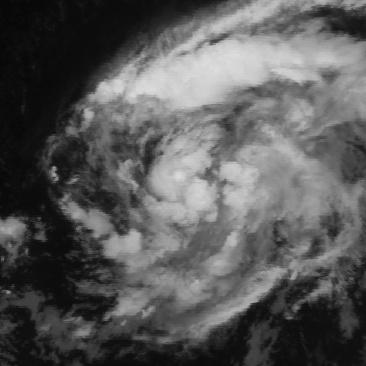

In [ ]:
#This cell test the access to the TFRecord file reading the first record available.
from PIL import Image                       # Import image class from PIL Library

for example in ds_train.take(1):            #Iterates only over one element taking only the first record, this
                                            #This line calls the dstrain map definition in the previous cell and execute for first time the function read_one_whole_rec
  im, lb = example                          # The function read_one_whole_rec returns 2 elements, the image and the label.
  print("Windspeed is", str(lb.numpy()))    #  .numpy() converts the tensor with data type tf.float32 to a numpy array, in this case of dimension 0 (windspeed)
  display(Image.fromarray(tf.squeeze(im).numpy()))    # if the tensor img image has more than 2 dimensions and the additional dimension is 1  , squeeze eliminates the additonal non significant dimension,
                                                      # and preserve the required dimensions for a image (2 dimensions)



Windspeed is 34.0


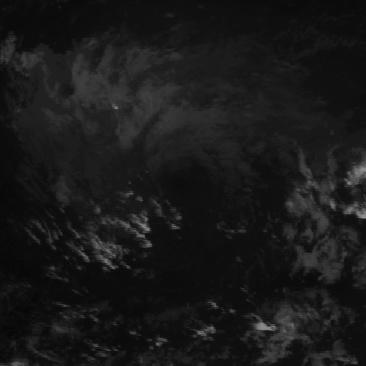

(366, 366, 1)


In [ ]:
for example in ds_val.take(1):
  im, lb = example
  print("Windspeed is", str(lb.numpy()))
  display(Image.fromarray(tf.squeeze(im).numpy()))
  print(im.shape)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**Calculations and Batching**
Determine the number of records to send to the model per batch (batch size) and the number of batches for each epoch (steps per epoch)

In [ ]:
#to improve streaming performance
AUTO = tf.data.experimental.AUTOTUNE

TOTAL_RECORDS = ds_val.reduce(np.int64(0), lambda x, _: x + 1)
BATCH_SIZE_PER_REPLICA = 24
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA# * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = (TOTAL_RECORDS // GLOBAL_BATCH_SIZE).numpy()
print("Steps per epoch", str(STEPS_PER_EPOCH))    # BatchSize*Steps= Total Records = 1 Epoch

Steps per epoch 178


In [ ]:
# to ensure all batches are the same size, use drop_remainder=True
batched_ds_train = ds_train.batch(GLOBAL_BATCH_SIZE, drop_remainder=True).prefetch(AUTO)
print(batched_ds_train)

batched_ds_val = ds_val.batch(GLOBAL_BATCH_SIZE, drop_remainder=True).prefetch(AUTO)
print(batched_ds_val)

<_PrefetchDataset element_spec=(TensorSpec(shape=(24, 366, 366, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(24,), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(24, 366, 366, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(24,), dtype=tf.float32, name=None))>


####Model
Create model, associate it with the TPU strategy, then fit.  

In [ ]:
IMG_SIZE = 366
EPOCHS = 100

def create_compile_model_with_bn_dropout_366():
  model = Sequential(
      [
        #seeing OK performance with fullsize images,
        #but preprocessing is an option if needed to make training faster.
        #preprocessing.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest"),
        #preprocessing.Rescaling(1./255)
      ]
  )
  model.add(Conv2D(32, (7,7), padding='same', activation='selu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='selu'))
  model.add(Dense(1, activation='linear'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
  return model

In [ ]:
#associate with TPU strategy
#with strategy.scope():
model = create_compile_model_with_bn_dropout_366()

#setup to save the best model because the last is not necessarily the best.
d = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
checkpoint_filename = '/content/drive/MyDrive/data/models/best-' + d +'.keras'
checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_mse', verbose=1, save_best_only=True, mode='min')

#extra logging to know when fitting starts
print(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %I:%M:%S %p"))

history = model.fit(batched_ds_train.repeat(), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, verbose=1, \
                    validation_data=batched_ds_val, callbacks=[checkpoint])

final_filename = '/content/drive/MyDrive/data/models/final-' + d + '.keras'
model.save(final_filename)
print("just saved model" )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2024-08-09 11:11:29 PM
Epoch 1/100
  2/178 ━━━━━━━━━━━━━━━━━━━━ 1:37:57 33s/step - loss: 3562.2305 - mae: 59.1982 - mape: 99.5422 - mse: 3562.2305

KeyboardInterrupt: 

In [ ]:
model.save(final_filename)
print("just saved model" )

just saved model
